# Studienarbeit ComputerVision 2
## Differences and Limitations of Unet and SegNet

---

In [16]:
# relevant imports
from torch import nn, optim
from torchsummary import summary
from torchvision.transforms import transforms
from PIL import Image
from ray.train import Checkpoint
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
from typing import List
from matplotlib import pyplot as plt
import pandas as pd
from ray.air import session
from pathlib import Path
from torch.utils.data import random_split
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms.functional as F
import torch
import torchmetrics as TM
from torch.utils.data import DataLoader
import os

#### Modelarchitecture
![segnet_graph.png](https://production-media.paperswithcode.com/methods/segnet_Vorazx7.png)


In [17]:
class SegNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SegNet, self).__init__()

        # Encoder Blocks
        self.encoder_block_1 = SegNet._conv_block(input_size, 32)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.encoder_block_2 = SegNet._conv_block(32, 64)
        self.max_pool_2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.encoder_block_3 = SegNet._conv_block(64, 128)
        self.max_pool_3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.encoder_block_4 = SegNet._conv_block(128, 256)
        self.max_pool_4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # Bottleneck
        self.bottle_neck_block_1 = SegNet._conv_block(256, 512)
        self.max_pool_5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.max_unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        # Decoder Blocks
        self.decoder_block_5 = SegNet._conv_block(512, 256)

        self.unpool_block_4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_4 = SegNet._conv_block(256, 128)

        self.unpool_block_3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_3 = SegNet._conv_block(128, 64)

        self.unpool_block_2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_2 = SegNet._conv_block(64, 32)

        self.unpool_block_1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_block_1 = SegNet._conv_block(32, 32)

        self.fc = nn.Conv2d(32, output_size, kernel_size=1)

    def forward(self, x):
        e1 = self.encoder_block_1(x)
        e1_1, i1 = self.max_pool_1(e1)

        e2 = self.encoder_block_2(e1_1)
        e2_1, i2 = self.max_pool_2(e2)

        e3 = self.encoder_block_3(e2_1)
        e3_1, i3 = self.max_pool_3(e3)

        e4 = self.encoder_block_4(e3_1)
        e4_1, i4 = self.max_pool_4(e4)

        b = self.bottle_neck_block_1(e4_1)
        b, i5 = self.max_pool_5(b)
        b_unpool = self.max_unpool(b, i5)
        b = self.decoder_block_5(b_unpool)

        d4 = self.unpool_block_4(b, i4)
        d4 = self.decoder_block_4(d4)

        d3 = self.unpool_block_3(d4, i3)
        d3 = self.decoder_block_3(d3)

        d2 = self.unpool_block_2(d3, i2)
        d2 = self.decoder_block_2(d2)

        d1 = self.unpool_block_1(d2, i1)
        d1 = self.decoder_block_1(d1)

        return self.fc(d1)


    @staticmethod
    def _conv_block(input_size, output_size):
        return nn.Sequential(
            nn.Conv2d(input_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_size, output_size, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(output_size),
            nn.ReLU(inplace=True))

In [3]:
segnet = SegNet(3, 1)
segnet.cuda()
summary(segnet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]           9,216
       BatchNorm2d-5         [-1, 32, 256, 256]              64
              ReLU-6         [-1, 32, 256, 256]               0
         MaxPool2d-7  [[-1, 32, 128, 128], [-1, 32, 128, 128]]               0
            Conv2d-8         [-1, 64, 128, 128]          18,432
       BatchNorm2d-9         [-1, 64, 128, 128]             128
             ReLU-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]          36,864
      BatchNorm2d-12         [-1, 64, 128, 128]             128
             ReLU-13         [-1, 64, 128, 128]               0
        MaxPool2d-14  [[

---

#### Datapreparation

In [18]:
transform_image = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5]),
])

transform_mask = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda mask: mask - 1),
])

class SynchronizedOxfordIIITPet(OxfordIIITPet):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def __getitem__(self, index):
        image, mask = super().__getitem__(index)

        if torch.rand(1) < .5:
            i, j, h, w = transforms.RandomResizedCrop.get_params(image, (.8, 1.0), (3.0 / 4.0, 4.0 / 3.0))
            image, mask = F.resized_crop(image, i, j, h, w, (256, 256)), F.resized_crop(mask, i, j, h, w, (256, 256), Image.NEAREST)
        if torch.rand(1) < .5:
            image, mask = F.hflip(image), F.hflip(mask)
        if torch.rand(1) < .5:
            image, mask = F.vflip(image), F.vflip(mask)

        return image, mask

In [19]:
dataset = SynchronizedOxfordIIITPet(
    root="~/res",
    split="trainval",
    target_types=["segmentation"],
    download=True,
    transform=transform_image,
    target_transform=transform_mask
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

torch.manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

test_dataset = OxfordIIITPet(
    root="~/res",
    split="test",
    target_types=["segmentation"],
    download=True,
    transform=transform_image,
    target_transform=transform_mask
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8595948..1.0].


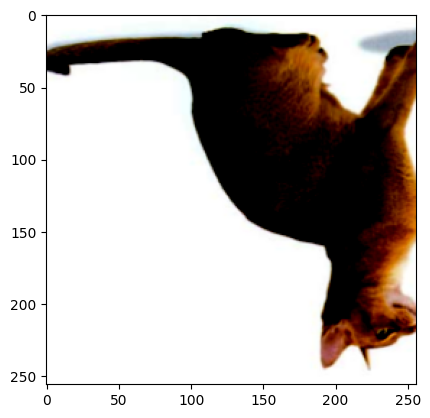

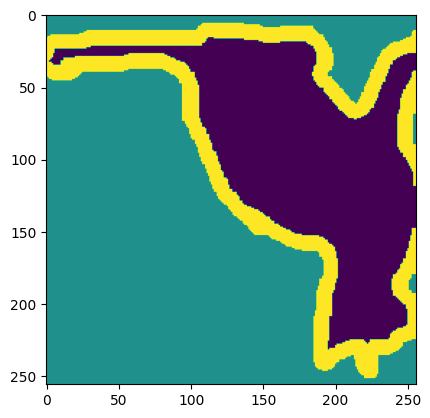

In [37]:
i, m = train_dataset[1]
plt.imshow(i.permute(1,2,0))
plt.show()
plt.imshow(m[0])

In [52]:
dataset.classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

---

#### Training

In [38]:
def validation_loop(model: nn.Module, validation_dataloader: DataLoader, loss_fn, device) -> float:
    """
    Validation loop for the CNN
    :param model: neural network
    :param validation_dataloader: dataloader for the validation set
    :param loss_fn: loss function
    :param device: device on which to perform the validation
    :return: validation loss
    """
    running_val_loss: float = 0.
    model.eval()
    with torch.no_grad():
        for i, vdata in enumerate(validation_dataloader):
            inputs, targets = vdata
            inputs, targets = inputs.to(device), targets.squeeze(1).long().to(device)

            vloss = loss_fn(model(inputs), targets)
            running_val_loss += vloss.item()
        running_val_loss /= (i + 1)

    return running_val_loss

In [39]:
def train_loop(model: nn.Module, train_dataloader: DataLoader, loss_fn, optimizer, device) -> float:
    """
    Main minibatch train loop for the CNN
    :param model: neural network
    :param train_dataloader: dataloader for the train set
    :param loss_fn: loss function
    :param optimizer: optimizer
    :param device: device on which to perform the training
    :return: train loss
    """
    running_tr_loss: float = 0.
    for i, data in enumerate(train_dataloader):
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.squeeze(1).long().to(device)

        yhats = model(inputs)
        optimizer.zero_grad()
        tloss = loss_fn(yhats, targets)

        tloss.backward()
        optimizer.step()

        running_tr_loss += tloss.item()
    running_tr_loss /= (i + 1)

    return running_tr_loss

In [40]:
def train_segnet(
        config: dict,
        train_dataset,
        validation_dataset,
        epochs: int,
        apply_scheduler: bool = True,
        return_flag: bool = False) -> dict | None:
    """
    Prepared train loop for ray parameter tuning.
    Training components:
        - model: CNN
        - loss function: CrossEntropyLoss
        - optimizer: Adam
        - scheduler: ExponentialLR (optional)

    :param config: dict of hyperparameters
    :param train_dataset:
    :param validation_dataset:
    :param epochs: number of epochs to train
    :param apply_scheduler: weather scheduler should be used or not
    :param return_flag: weather to return the model and losses or not
    :return: training results
    """

    device: torch.device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
    print(device)
    model: nn.Module = SegNet(3, 3).to(device)

    loss_fn = nn.CrossEntropyLoss()

    optim_params: dict = {
        'lr': config["lr"],
    }
    optimizer: optim.Adam = optim.Adam(model.parameters(), **optim_params)

        
    train_dataloader: DataLoader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
    validation_dataloader: DataLoader = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=4)
    
    scheduler = OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_dataloader), epochs=epochs, pct_start=0.3)

    train_losses: List[float] = []
    val_losses: List[float] = []

    print('Start training...')
    for epoch in tqdm(range(epochs)):
        print('Start: ', epoch)
        model.train()

        # Train loop to iterate over the dataloader batches
        running_tr_loss: float = train_loop(model, train_dataloader, loss_fn, optimizer, device)
        if apply_scheduler:
            scheduler.step()

        # Validation loop
        running_val_loss: float = validation_loop(model, validation_dataloader, loss_fn, device)

        print(epoch, " - ", 'tr_loss:', running_tr_loss, 'val_loss:', running_val_loss)
        train_losses.append(running_tr_loss)
        val_losses.append(running_val_loss)

        # Save a checkpoint from the model
        os.makedirs("res/model", exist_ok=True)
        torch.save(
            (model.state_dict(), optimizer.state_dict()), "res/model/checkpoint.pt")
        checkpoint: Checkpoint = Checkpoint.from_directory("res/model")
        session.report({"val_loss": running_val_loss,
                        "train_loss": running_tr_loss}, checkpoint=checkpoint)

    if return_flag:
        return {"train_losses": train_losses,
                "val_losses": val_losses,
                "model": model}

---

#### Training with parameter

In [41]:
config = {'lr': 0.001}

res = train_segnet(config, train_dataset, val_dataset, 100, return_flag=True, apply_scheduler=True)

cuda:6
Start training...


  0%|          | 0/100 [00:00<?, ?it/s]

Start:  0
0  -  tr_loss: 0.8587791012681049 val_loss: 1.1598797142505646


  1%|          | 1/100 [00:14<24:41, 14.96s/it]

Start:  1
1  -  tr_loss: 0.7185405738975691 val_loss: 0.9319819758335749


  2%|▏         | 2/100 [00:30<24:42, 15.13s/it]

Start:  2
2  -  tr_loss: 0.6775181552638179 val_loss: 0.7139444549878439


  3%|▎         | 3/100 [00:45<24:28, 15.13s/it]

Start:  3
3  -  tr_loss: 0.6521480860917465 val_loss: 0.7105804334084193


  4%|▍         | 4/100 [01:00<24:29, 15.31s/it]

Start:  4
4  -  tr_loss: 0.6284650175467782 val_loss: 0.6784665038188299


  5%|▌         | 5/100 [01:16<24:11, 15.28s/it]

Start:  5
5  -  tr_loss: 0.6056479202664417 val_loss: 0.6201800853013992


  6%|▌         | 6/100 [01:31<23:49, 15.20s/it]

Start:  6
6  -  tr_loss: 0.5830001468243806 val_loss: 0.6014077663421631


  7%|▋         | 7/100 [01:45<23:18, 15.04s/it]

Start:  7
7  -  tr_loss: 0.573460825111555 val_loss: 0.6050353993972143


  8%|▊         | 8/100 [02:00<23:01, 15.01s/it]

Start:  8
8  -  tr_loss: 0.5589977088181869 val_loss: 0.6788757791121801


  9%|▉         | 9/100 [02:15<22:40, 14.96s/it]

Start:  9
9  -  tr_loss: 0.5389710593482723 val_loss: 0.6426186760266622


 10%|█         | 10/100 [02:30<22:21, 14.90s/it]

Start:  10
10  -  tr_loss: 0.5363360319448554 val_loss: 0.5486499220132828


 11%|█         | 11/100 [02:44<21:52, 14.75s/it]

Start:  11
11  -  tr_loss: 0.507449680696363 val_loss: 0.848450298110644


 12%|█▏        | 12/100 [02:59<21:27, 14.63s/it]

Start:  12
12  -  tr_loss: 0.5038481873014699 val_loss: 0.5196961785356203


 13%|█▎        | 13/100 [03:13<20:53, 14.41s/it]

Start:  13
13  -  tr_loss: 0.4866824493460033 val_loss: 0.46858275681734085


 14%|█▍        | 14/100 [03:27<20:41, 14.43s/it]

Start:  14
14  -  tr_loss: 0.4730691734863364 val_loss: 0.4728037466605504


 15%|█▌        | 15/100 [03:42<20:33, 14.51s/it]

Start:  15
15  -  tr_loss: 0.4620537220135979 val_loss: 0.5288968135913213


 16%|█▌        | 16/100 [03:56<20:17, 14.49s/it]

Start:  16
16  -  tr_loss: 0.4593119556489198 val_loss: 0.44406449794769287


 17%|█▋        | 17/100 [04:11<20:11, 14.60s/it]

Start:  17
17  -  tr_loss: 0.43913022655507794 val_loss: 0.4366643726825714


 18%|█▊        | 18/100 [04:25<19:49, 14.50s/it]

Start:  18
18  -  tr_loss: 0.4383913278579712 val_loss: 0.4874069218834241


 19%|█▉        | 19/100 [04:40<19:39, 14.57s/it]

Start:  19
19  -  tr_loss: 0.4366725579552028 val_loss: 0.4646090194582939


 20%|██        | 20/100 [04:55<19:27, 14.60s/it]

Start:  20
20  -  tr_loss: 0.4253041446208954 val_loss: 0.448451725145181


 21%|██        | 21/100 [05:09<19:15, 14.63s/it]

Start:  21
21  -  tr_loss: 0.42524500774300616 val_loss: 0.43756436308224994


 22%|██▏       | 22/100 [05:24<18:54, 14.55s/it]

Start:  22
22  -  tr_loss: 0.4069395616002705 val_loss: 0.41707494109869003


 23%|██▎       | 23/100 [05:38<18:42, 14.58s/it]

Start:  23
23  -  tr_loss: 0.40701265179592633 val_loss: 0.4205951740344365


 24%|██▍       | 24/100 [05:53<18:29, 14.60s/it]

Start:  24
24  -  tr_loss: 0.3981563053701235 val_loss: 0.3992264394958814


 25%|██▌       | 25/100 [06:07<18:07, 14.50s/it]

Start:  25
25  -  tr_loss: 0.3974729413571565 val_loss: 0.41875874251127243


 26%|██▌       | 26/100 [06:22<18:04, 14.66s/it]

Start:  26
26  -  tr_loss: 0.38773684138837067 val_loss: 0.3845818688472112


 27%|██▋       | 27/100 [06:37<17:45, 14.60s/it]

Start:  27
27  -  tr_loss: 0.3768962893797004 val_loss: 0.3914189164837201


 28%|██▊       | 28/100 [06:51<17:26, 14.53s/it]

Start:  28
28  -  tr_loss: 0.36542286237944727 val_loss: 0.3794749801357587


 29%|██▉       | 29/100 [07:06<17:13, 14.55s/it]

Start:  29
29  -  tr_loss: 0.3593159564163374 val_loss: 0.4020423541466395


 30%|███       | 30/100 [07:21<17:08, 14.70s/it]

Start:  30
30  -  tr_loss: 0.3652788588534231 val_loss: 0.37944430361191434


 31%|███       | 31/100 [07:36<16:56, 14.73s/it]

Start:  31
31  -  tr_loss: 0.35983532602372376 val_loss: 0.373761847615242


 32%|███▏      | 32/100 [07:50<16:32, 14.60s/it]

Start:  32
32  -  tr_loss: 0.3509216872246369 val_loss: 0.39294591297705966


 33%|███▎      | 33/100 [08:05<16:21, 14.65s/it]

Start:  33
33  -  tr_loss: 0.348922196937644 val_loss: 0.4344171832005183


 34%|███▍      | 34/100 [08:20<16:11, 14.72s/it]

Start:  34
34  -  tr_loss: 0.3383111163325932 val_loss: 0.37597138931353885


 35%|███▌      | 35/100 [08:34<15:46, 14.57s/it]

Start:  35
35  -  tr_loss: 0.3411283201497534 val_loss: 0.3602490822474162


 36%|███▌      | 36/100 [08:48<15:32, 14.57s/it]

Start:  36
36  -  tr_loss: 0.33055781799813977 val_loss: 0.3534875785311063


 37%|███▋      | 37/100 [09:03<15:16, 14.55s/it]

Start:  37
37  -  tr_loss: 0.3233087859723879 val_loss: 0.3398175736268361


 38%|███▊      | 38/100 [09:18<15:07, 14.63s/it]

Start:  38
38  -  tr_loss: 0.3225814998149872 val_loss: 0.35621345043182373


 39%|███▉      | 39/100 [09:33<14:57, 14.71s/it]

Start:  39
39  -  tr_loss: 0.3247772053531978 val_loss: 0.3656979873776436


 40%|████      | 40/100 [09:48<14:45, 14.77s/it]

Start:  40
40  -  tr_loss: 0.3231613759113395 val_loss: 0.34882285942633945


 41%|████      | 41/100 [10:02<14:26, 14.69s/it]

Start:  41
41  -  tr_loss: 0.3104193307783293 val_loss: 0.32857292393843335


 42%|████▏     | 42/100 [10:17<14:12, 14.70s/it]

Start:  42
42  -  tr_loss: 0.3018132338057394 val_loss: 0.33147916197776794


 43%|████▎     | 43/100 [10:31<13:56, 14.67s/it]

Start:  43
43  -  tr_loss: 0.3026682864064756 val_loss: 0.32744644582271576


 44%|████▍     | 44/100 [10:46<13:39, 14.64s/it]

Start:  44
44  -  tr_loss: 0.2938572732002839 val_loss: 0.32774323721726734


 45%|████▌     | 45/100 [11:01<13:29, 14.72s/it]

Start:  45
45  -  tr_loss: 0.3015565794447194 val_loss: 0.34835410366455716


 46%|████▌     | 46/100 [11:16<13:14, 14.71s/it]

Start:  46
46  -  tr_loss: 0.2959103396405344 val_loss: 0.33582445482412976


 47%|████▋     | 47/100 [11:30<12:55, 14.63s/it]

Start:  47
47  -  tr_loss: 0.2874664946094803 val_loss: 0.3312142292658488


 48%|████▊     | 48/100 [11:45<12:49, 14.80s/it]

Start:  48
48  -  tr_loss: 0.28459327344013297 val_loss: 0.33488108962774277


 49%|████▉     | 49/100 [12:00<12:37, 14.85s/it]

Start:  49
49  -  tr_loss: 0.28436138545689377 val_loss: 0.3368586252133052


 50%|█████     | 50/100 [12:15<12:18, 14.76s/it]

Start:  50
50  -  tr_loss: 0.28094970953205356 val_loss: 0.3524463127056758


 51%|█████     | 51/100 [12:29<12:01, 14.73s/it]

Start:  51
51  -  tr_loss: 0.27905776999566867 val_loss: 0.32862015068531036


 52%|█████▏    | 52/100 [12:44<11:47, 14.73s/it]

Start:  52
52  -  tr_loss: 0.2778379162368567 val_loss: 0.32552200307448703


 53%|█████▎    | 53/100 [12:59<11:32, 14.73s/it]

Start:  53
53  -  tr_loss: 0.2751463641938956 val_loss: 0.3392922133207321


 54%|█████▍    | 54/100 [13:13<11:12, 14.61s/it]

Start:  54
54  -  tr_loss: 0.2803405701466229 val_loss: 0.3227768838405609


 55%|█████▌    | 55/100 [13:27<10:53, 14.52s/it]

Start:  55
55  -  tr_loss: 0.2652922855771106 val_loss: 0.3282250538468361


 56%|█████▌    | 56/100 [13:42<10:37, 14.50s/it]

Start:  56
56  -  tr_loss: 0.26143880285646603 val_loss: 0.32513196518023807


 57%|█████▋    | 57/100 [13:57<10:32, 14.71s/it]

Start:  57
57  -  tr_loss: 0.2650872323176135 val_loss: 0.3182034691174825


 58%|█████▊    | 58/100 [14:11<10:12, 14.59s/it]

Start:  58
58  -  tr_loss: 0.2558027842770452 val_loss: 0.34833811471859616


 59%|█████▉    | 59/100 [14:26<09:56, 14.54s/it]

Start:  59
59  -  tr_loss: 0.2579050880411397 val_loss: 0.31402982771396637


 60%|██████    | 60/100 [14:40<09:40, 14.50s/it]

Start:  60
60  -  tr_loss: 0.25362366988607077 val_loss: 0.3162425756454468


 61%|██████    | 61/100 [14:54<09:20, 14.38s/it]

Start:  61
61  -  tr_loss: 0.2444896247723828 val_loss: 0.3302346542477608


 62%|██████▏   | 62/100 [15:08<09:01, 14.26s/it]

Start:  62
62  -  tr_loss: 0.23980939453062805 val_loss: 0.3204553971687953


 63%|██████▎   | 63/100 [15:23<08:48, 14.29s/it]

Start:  63
63  -  tr_loss: 0.24151961958926657 val_loss: 0.29445432623227435


 64%|██████▍   | 64/100 [15:38<08:45, 14.59s/it]

Start:  64
64  -  tr_loss: 0.24325554785521133 val_loss: 0.2946398506561915


 65%|██████▌   | 65/100 [15:53<08:33, 14.68s/it]

Start:  65
65  -  tr_loss: 0.23867187357467154 val_loss: 0.3077914093931516


 66%|██████▌   | 66/100 [16:08<08:21, 14.76s/it]

Start:  66
66  -  tr_loss: 0.23404793927203055 val_loss: 0.31956922511259717


 67%|██████▋   | 67/100 [16:23<08:10, 14.87s/it]

Start:  67
67  -  tr_loss: 0.23578953483830328 val_loss: 0.3455594554543495


 68%|██████▊   | 68/100 [16:38<07:54, 14.84s/it]

Start:  68
68  -  tr_loss: 0.2306311613191729 val_loss: 0.3247960607210795


 69%|██████▉   | 69/100 [16:52<07:36, 14.72s/it]

Start:  69
69  -  tr_loss: 0.22651336666034616 val_loss: 0.30242271224657696


 70%|███████   | 70/100 [17:07<07:21, 14.73s/it]

Start:  70
70  -  tr_loss: 0.23240237942208414 val_loss: 0.30133060241738957


 71%|███████   | 71/100 [17:21<07:03, 14.59s/it]

Start:  71
71  -  tr_loss: 0.2213237599834152 val_loss: 0.3343251124024391


 72%|███████▏  | 72/100 [17:36<06:49, 14.63s/it]

Start:  72
72  -  tr_loss: 0.21784778619590012 val_loss: 0.3068363169829051


 73%|███████▎  | 73/100 [17:51<06:42, 14.90s/it]

Start:  73
73  -  tr_loss: 0.22150423086207846 val_loss: 0.3333551113804181


 74%|███████▍  | 74/100 [18:06<06:20, 14.65s/it]

Start:  74
74  -  tr_loss: 0.22514026968375497 val_loss: 0.32185723384221393


 75%|███████▌  | 75/100 [18:20<06:07, 14.71s/it]

Start:  75
75  -  tr_loss: 0.21604712339846985 val_loss: 0.30422932902971905


 76%|███████▌  | 76/100 [18:35<05:51, 14.64s/it]

Start:  76
76  -  tr_loss: 0.22170991353366687 val_loss: 0.3200242618719737


 77%|███████▋  | 77/100 [18:50<05:39, 14.75s/it]

Start:  77
77  -  tr_loss: 0.21745204374842023 val_loss: 0.3133889113863309


 78%|███████▊  | 78/100 [19:05<05:24, 14.75s/it]

Start:  78
78  -  tr_loss: 0.21611164704613064 val_loss: 0.32604286322991055


 79%|███████▉  | 79/100 [19:19<05:06, 14.61s/it]

Start:  79
79  -  tr_loss: 0.2159912119741025 val_loss: 0.32906503478686017


 80%|████████  | 80/100 [19:34<04:55, 14.80s/it]

Start:  80
80  -  tr_loss: 0.21002457388069318 val_loss: 0.3262377604842186


 81%|████████  | 81/100 [19:48<04:37, 14.61s/it]

Start:  81
81  -  tr_loss: 0.2041820796287578 val_loss: 0.30397411560018855


 82%|████████▏ | 82/100 [20:03<04:23, 14.63s/it]

Start:  82
82  -  tr_loss: 0.2041374150177707 val_loss: 0.3328278462092082


 83%|████████▎ | 83/100 [20:18<04:12, 14.83s/it]

Start:  83
83  -  tr_loss: 0.20047845853411633 val_loss: 0.3177981774012248


 84%|████████▍ | 84/100 [20:33<03:56, 14.79s/it]

Start:  84
84  -  tr_loss: 0.19884505544019782 val_loss: 0.3133796751499176


 85%|████████▌ | 85/100 [20:48<03:41, 14.76s/it]

Start:  85
85  -  tr_loss: 0.18977223142333652 val_loss: 0.3174045297006766


 86%|████████▌ | 86/100 [21:02<03:26, 14.76s/it]

Start:  86
86  -  tr_loss: 0.18969258212524912 val_loss: 0.31185705463091534


 87%|████████▋ | 87/100 [21:17<03:10, 14.65s/it]

Start:  87
87  -  tr_loss: 0.19183440992365713 val_loss: 0.3081632914642493


 88%|████████▊ | 88/100 [21:31<02:53, 14.49s/it]

Start:  88
88  -  tr_loss: 0.19668934656226117 val_loss: 0.31383446604013443


 89%|████████▉ | 89/100 [21:46<02:40, 14.58s/it]

Start:  89
89  -  tr_loss: 0.1911836664961732 val_loss: 0.30992043515046436


 90%|█████████ | 90/100 [22:00<02:24, 14.42s/it]

Start:  90
90  -  tr_loss: 0.18782884562792984 val_loss: 0.3125678946574529


 91%|█████████ | 91/100 [22:15<02:11, 14.64s/it]

Start:  91
91  -  tr_loss: 0.1827231554881386 val_loss: 0.3183044244845708


 92%|█████████▏| 92/100 [22:30<01:58, 14.75s/it]

Start:  92
92  -  tr_loss: 0.18287715283424957 val_loss: 0.3144788568218549


 93%|█████████▎| 93/100 [22:44<01:42, 14.68s/it]

Start:  93
93  -  tr_loss: 0.18733499685059424 val_loss: 0.31910059601068497


 94%|█████████▍| 94/100 [23:00<01:28, 14.80s/it]

Start:  94
94  -  tr_loss: 0.18816205308489178 val_loss: 0.3376057023803393


 95%|█████████▌| 95/100 [23:14<01:13, 14.63s/it]

Start:  95
95  -  tr_loss: 0.18452290542747662 val_loss: 0.327349287768205


 96%|█████████▌| 96/100 [23:28<00:57, 14.48s/it]

Start:  96
96  -  tr_loss: 0.1817063922467439 val_loss: 0.307787150144577


 97%|█████████▋| 97/100 [23:43<00:43, 14.53s/it]

Start:  97
97  -  tr_loss: 0.17528463381788004 val_loss: 0.32430756092071533


 98%|█████████▊| 98/100 [23:57<00:28, 14.50s/it]

Start:  98
98  -  tr_loss: 0.1735486511303031 val_loss: 0.3100328780710697


 99%|█████████▉| 99/100 [24:12<00:14, 14.57s/it]

Start:  99
99  -  tr_loss: 0.17586711534987326 val_loss: 0.324076883494854


100%|██████████| 100/100 [24:27<00:00, 14.67s/it]


In [42]:
val_losses = res['val_losses']
tr_losses = res['train_losses']
model = res['model']

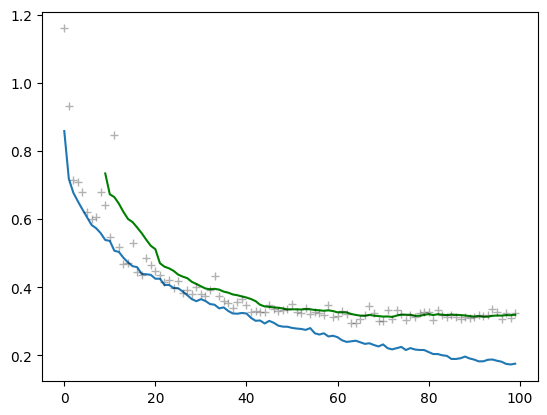

In [43]:
plt.plot(tr_losses)
plt.plot(pd.Series(val_losses).rolling(10).mean(), color='g')
plt.plot(val_losses, 'k+', alpha=0.3)
plt.show()

---

#### Evaluation

In [44]:
torch.save(model, '../../res/checkpoints/segnet_pets_full.pt')
torch.save(model.state_dict(), '../../res/checkpoints/segnet_pets.pt')

In [20]:
def load_checkpoint(path: Path, model: torch.nn.Module) -> torch.nn.Module:
    """
    Helper method to load a model from a checkpoint
    :param path: path to checkpoint
    :param model: model which should use the checkpoint
    :return: loaded model
    """
    device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    checkpoint = torch.load(path, map_location=device, weights_only=True)
    model.load_state_dict(checkpoint)
    return model

In [21]:
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
device: torch.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = SegNet(3, 3).to(device)

net = load_checkpoint(Path('../../res/checkpoints/segnet_pets.pt'), net)

In [22]:
def evaluate_model(model: torch.nn.Module, data_loader: DataLoader, device) -> None:
    """
    Evaluate the pixel accuracy and the Intersection over Union (IoU) for the model
    :param model: neural network
    :param data_loader: torch DataLoader
    :param device: device on which to perform the evaluation
    :return: None
    """
    model.eval()

    iou_scores = []
    pixel_acc_scores = []
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            pred = nn.Softmax(dim=1)(outputs)
            pred = pred.argmax(dim=1)
            pred = pred.unsqueeze(1).long().to(device)

            iou = TM.classification.MulticlassJaccardIndex(35, average='macro').to(device)
            iou_score = iou(pred, targets)
            iou_scores.append(iou_score.item())

            pixel_metric = TM.classification.MulticlassAccuracy(35, average='macro').to(device)
            pixel_acc_score = pixel_metric(pred, targets)
            pixel_acc_scores.append(pixel_acc_score.item())

        iou_tensor = torch.FloatTensor(iou_scores)
        pixel_tensor = torch.FloatTensor(pixel_acc_scores)
        print(f"Iou: {iou_tensor.mean()}")
        print(f'Pixel Accuracy: {pixel_tensor.mean()}')


In [23]:
evaluate_model(net, test_dataloader, device)

100%|██████████| 58/58 [17:26<00:00, 18.05s/it]

Iou: 0.6738843321800232
Pixel Accuracy: 0.8097475171089172
